In [12]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd
import json
import requests
import numpy as np
import time
import ee; ee.Initialize()
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
import functools
import glob
import csv
import os
import itertools
from plotly import tools
import datetime


In [20]:
rvws = pd.read_csv('./rvws.csv',index_col=0,parse_dates=True)
tempname = 'RanchoVenadaWs_Air_Temp_Avg'
relname = 'RanchoVenadaWs_Relative_Humidity_Max'
airtemp_wssr = rvws[tempname]
relH_wssr = rvws[relname]
SVP_wssr = 610.7*10**(7.5*airtemp_wssr/(237.3+airtemp_wssr))#[Pa]
vpd_wssr = (((100-relH_wssr)/100)*SVP_wssr)/1000 #KPa
vpd_wssr = pd.DataFrame({'vpd':vpd_wssr.values}, index=vpd_wssr.index).sort_index().resample('1H').mean()
freq = '1H'

newnames = {'RanchoVenadaWs_Air_Temp_Avg':'Temp (F)', 
            'RanchoVenadaWs_Rainfall':'Precip (in)',
       'RanchoVenadaWs_Relative_Humidity_Max':'Rel humidity ( )',
       'RanchoVenadaWs_Barometric_Pressure':'Pressure (in Hg)',
       'RanchoVenadaWs_Wind_Speed_Avg':'Wind (mph)',
       'RanchoVenadaWs_Solar_Radiation_Avg':'Rad. (w/m2)'}
rvws = rvws[list(newnames)]
newcols = [newnames[item] for item in rvws.columns]
rvws.columns = newcols
rvws['Temp (F)'] = rvws['Temp (F)']*9/5. + 32.
rvws['Precip (in)'] = rvws['Precip (in)']*0.0393701
rvws['Pressure (in Hg)'] = rvws['Pressure (in Hg)']*0.02953
rvws['Wind (mph)'] = rvws['Wind (mph)']*2.23694
rvws['Rel humidity ( )'] = rvws['Rel humidity ( )']/100.0
rvws = rvws.resample(freq, how={'Temp (F)': np.mean,
                                'Precip (in)': np.sum,
                                'Pressure (in Hg)': np.mean,
                                'Wind (mph)':np.mean,
                                'Rel humidity ( )': np.mean, 
                                'Rad. (w/m2)':np.mean})


rvws['wy'] = [item.year if item.month>=1 and item.month<10 else item.year+1 for item in rvws.index]
rvws['Precip (in)'] = rvws.groupby('wy').apply(lambda item: item['Precip (in)'].cumsum()).values
# rvws = rvws.drop(['wy'], axis=1)

/home/pi/miniconda3/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



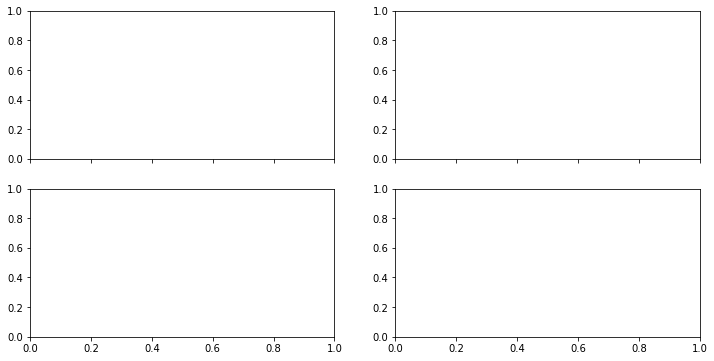

In [18]:
rvws = rvws[['Wind (mph)', 'Precip (in)', 'Temp (F)', 'Rel humidity ( )']]
f, axs = plt.subplots(2,2,sharex=True,figsize=(12,6))
